Using emotion labels: ['disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'unhappy']
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  


                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
          

 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_d

 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
          

                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
          

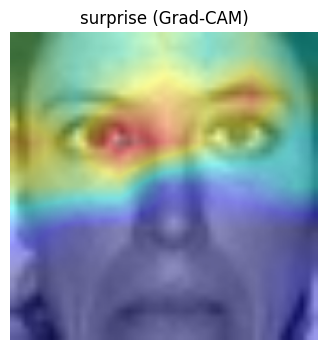

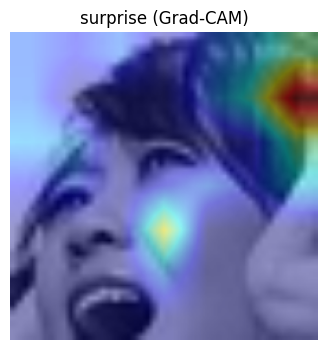

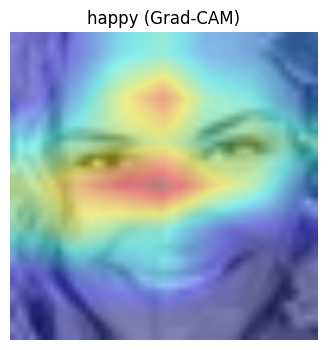

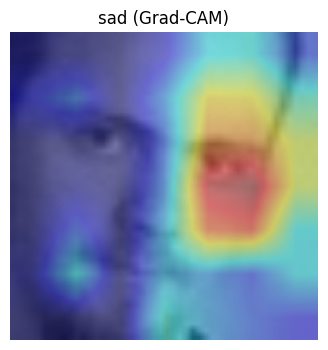

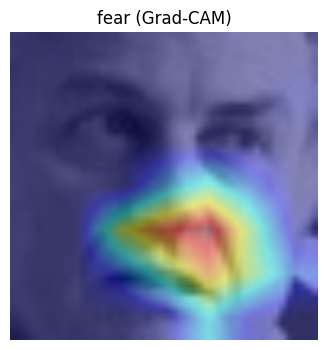

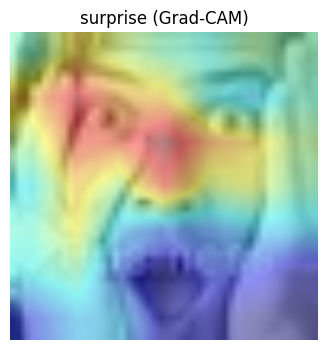

NameError: name 'df_log' is not defined

<Figure size 800x500 with 0 Axes>

In [2]:
# ---------------------------
# IMPORTS
# ---------------------------
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
import matplotlib.cm as cm

# ---------------------------
# CONFIGURATION
# ---------------------------
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_DIR = '.'  # Assume dataset is in same folder as notebook
emotion_labels = ['disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise','unhappy']
valid_extensions = ('.jpg', '.jpeg', '.png')

print("Using emotion labels:", emotion_labels)

# ---------------------------
# BUILD MODEL USING MobileNetV2
# ---------------------------
def build_emotion_model(num_classes):
    base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_emotion_model(len(emotion_labels))
print(model.summary())

# ---------------------------
# LOAD & AUGMENT DATA
# ---------------------------
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    classes=emotion_labels  # Force class order
)

val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    classes=emotion_labels
)

# ---------------------------
# TRAIN MODEL
# ---------------------------
EPOCHS = 16
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

# ---------------------------
# GRAD-CAM HELPER FUNCTION
# ---------------------------
def get_gradcam_heatmap(img_array, model, class_index, layer_name='Conv_1'):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-8)
    return heatmap.numpy()

# ---------------------------
# PREDICT & LOG + GRAD-CAM
# ---------------------------
emotion_log = []

for emotion_folder in emotion_labels:
    folder_path = os.path.join(DATASET_DIR, emotion_folder)
    if not os.path.isdir(folder_path):
        continue

    image_list = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]

    for i, img_name in enumerate(image_list):
        img_path = os.path.join(folder_path, img_name)

        try:
            img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            preds = model.predict(img_array, verbose=0)[0]
            emotion_idx = np.argmax(preds)
            predicted_emotion = emotion_labels[emotion_idx]
            confidence = preds[emotion_idx]

            emotion_log.append({
                "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "image": img_name,
                "predicted_emotion": predicted_emotion,
                "confidence": round(float(confidence), 2),
                "true_label": emotion_folder
            })

            # Grad-CAM only for 1st image in each class
            if i == 0:
                heatmap = get_gradcam_heatmap(img_array, model, emotion_idx)

                orig_img = cv2.imread(img_path)
                orig_img = cv2.resize(orig_img, (IMG_SIZE, IMG_SIZE))
                heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
                heatmap_resized = np.uint8(255 * heatmap_resized)
                heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
                superimposed_img = cv2.addWeighted(orig_img, 0.6, heatmap_color, 0.4, 0)

                # Show image
                plt.figure(figsize=(4, 4))
                plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
                plt.title(f"{predicted_emotion} (Grad-CAM)")
                plt.axis('off')
                plt.show()

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# ---------------------------
# SAVE & PLOT RESULTS
# ---------------------------chat
model.save("emotion_mobilenet_model.h5")
plt.figure(figsize=(8, 5))
plt.title("Predicted Emotion Distribution (MobileNetV2)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("mobilenet_emotion_distribution.png")
plt.show()


In [9]:
import cv2
from tensorflow.keras.models import load_model
model = load_model("emotion_mobilenet_model.h5")

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

    for (x, y, w, h) in faces:
        roi_color = frame[y:y + h, x:x + w]
        roi_resized = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
        roi_normalized = roi_resized / 255.0
        roi_expanded = np.expand_dims(roi_normalized, axis=0)

        preds = model.predict(roi_expanded, verbose=0)[0]
        emotion_idx = np.argmax(preds)
        label = f"{emotion_labels[emotion_idx]} ({preds[emotion_idx]*100:.1f}%)"

        # Draw bounding box & label
        cv2.rectangle(frame, (x, y), (x + w, y + h), (100, 255, 100), 2)
        cv2.putText(frame, label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    cv2.imshow("Real-time Emotion Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
